# CS535: Project Phase 2
## Language Classification
### Fall 2021
#### Group 26


Load Dataset + Feature extraction

In [ ]:
!pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=233f3b73051bb3f88bf13a46e681fb6ef2e78c5fde1db414e4e1d0d87d2e6db2
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features


In [ ]:
import numpy as np
import os
import glob
import python_speech_features as mfcc
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# define MFCC function
def get_MFCC(audio, sr):
    features = mfcc.mfcc(audio, sr, 0.025, 0.01, 13, appendEnergy = True)
    return np.mean(features, axis=0)

In [ ]:
os.chdir('/content/drive/MyDrive/Recordings')

ur = []
for f in glob.glob('ur*.wav'):
    wav_file = open(f)
    sr, audio = read(f)
    features_of_current = get_MFCC(audio, sr)
    ur.append(features_of_current)

ue = []
for f in glob.glob('ue*.wav'):
    wav_file = open(f)
    sr, audio = read(f)
    features_of_current = get_MFCC(audio, sr)
    ue.append(features_of_current)

en = []
for f in glob.glob('en*.wav'): 
    wav_file = open(f)
    sr, audio = read(f)
    features_of_current = get_MFCC(audio, sr)
    en.append(features_of_current)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: WavFileWarning: Chunk (non-data) not understood, skipping it.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: WavFileWarning: Chunk (non-data) not understood, skipping it.


In [ ]:
# make into np arrays
ur = np.array(ur)
ue = np.array(ue)
en = np.array(en)

In [ ]:
from sklearn.model_selection import train_test_split

# make target vectors for each class
ur_labels = np.full(ur.shape[0], "Urdu")
ue_labels = np.full(ue.shape[0], "Mixed")
en_labels = np.full(en.shape[0], "English")

# get X by concatenating ur ue en in order
X = np.concatenate((ur, ue, en))

# concatenate corresponding to X to get Y
Y = np.concatenate((ur_labels, ue_labels, en_labels))

# do an 80:20 split
x_tr, x_te, y_tr, y_te = train_test_split(X, Y, test_size=0.20, random_state=40)

# scale the features
scaler = preprocessing.StandardScaler().fit(x_tr)
x_tr = scaler.transform(x_tr)
x_te = scaler.transform(x_te)

print(x_tr.shape)
print(x_te.shape)

(13903, 13)
(3476, 13)


In [ ]:
# Check to make sure scaling happened correctly
np.std(x_tr, axis = 0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

#Part 1

Use scikit-learn’s implementation of one of the classifiers. 1) KNN 2) Decision Trees 3) Random Forest

Going with **KNN**

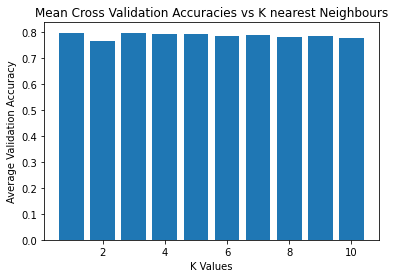

In [ ]:
# KNN 
# Hyper parameter tuning using cross validation
knn = KNeighborsClassifier()
k_nearest_values = np.arange(1, 11)
param_grid = {'n_neighbors': k_nearest_values}
knn_cv = GridSearchCV(knn, param_grid, cv=5)
knn_cv.fit(x_tr,y_tr)

# plotting validation results
cv_accuracies = knn_cv.cv_results_['mean_test_score']
plt.bar(k_nearest_values, cv_accuracies)
plt.ylabel('Average Validation Accuracy')
plt.xlabel('K Values')
plt.title("Mean Cross Validation Accuracies vs K nearest Neighbours")
plt.show()

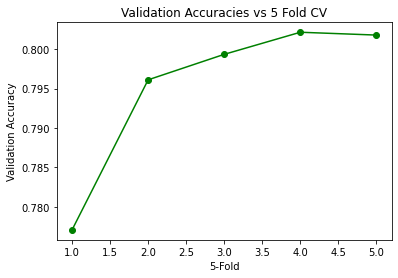

Mean Accuracy: 0.7952969404411745


In [ ]:
# cross validation on optimal k chosen using accuracy values from plot
best_k_value = 3
knn = KNeighborsClassifier(n_neighbors=best_k_value)
cv_results = cross_val_score(knn, x_tr, y_tr, cv=5)
plt.plot([1,2,3,4,5], cv_results, marker='o', color='green')
plt.ylabel('Validation Accuracy')
plt.xlabel('5-Fold')
plt.title("Validation Accuracies vs 5 Fold CV")
plt.show()
print("Mean Accuracy:", cv_results.mean())

In [ ]:
# training on optimal value
knn.fit(x_tr, y_tr)

# testing
y_pred = knn.predict(x_te)

# evaluation
acc = accuracy_score(y_te, y_pred)
cm = confusion_matrix(y_te, y_pred)

# print performance metrics
print("Accuracy: ", acc*100, "%")
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report: ")
print(classification_report(y_te, y_pred))

Accuracy:  82.22094361334868 %

Confusion Matrix:
[[ 865   95   89]
 [ 154 1169   62]
 [ 122   96  824]]

Classification Report: 
              precision    recall  f1-score   support

     English       0.76      0.82      0.79      1049
       Mixed       0.86      0.84      0.85      1385
        Urdu       0.85      0.79      0.82      1042

    accuracy                           0.82      3476
   macro avg       0.82      0.82      0.82      3476
weighted avg       0.82      0.82      0.82      3476



# Part 2

Use scikit-learn’s Kernelized Support Vector implementation to train and test
the Kernelized SVM

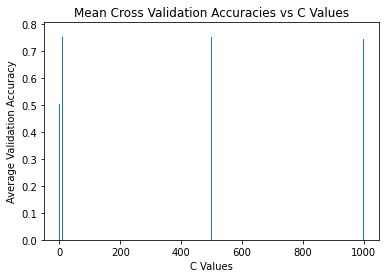

In [ ]:
from sklearn import svm

#Create a svm Classifier
ksvm = svm.SVC(kernel='rbf')
c_values = [0.1,1,10,100, 500, 700,1000]
param_grid = {'C': c_values}
svm_cv = GridSearchCV(ksvm, param_grid, cv=5)
svm_cv.fit(x_tr,y_tr)

# plotting validation results
cv_accuracies = svm_cv.cv_results_['mean_test_score']
plt.bar(c_values, cv_accuracies)
plt.ylabel('Average Validation Accuracy')
plt.xlabel('C Values')
plt.title("Mean Cross Validation Accuracies vs C Values")
plt.show()

In [ ]:
svm_cv.best_params_

{'C': 100}

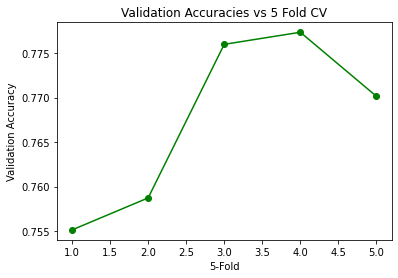

Mean Accuracy: 0.76746116375508


In [ ]:
# cross validation on model with best c
best_c = svm_cv.best_params_['C']
ksvm = svm.SVC(kernel = 'rbf' , C = best_c)
cv_results = cross_val_score(ksvm, x_tr, y_tr, cv=5)
plt.plot([1,2,3,4,5], cv_results, marker='o', color='green')
plt.ylabel('Validation Accuracy')
plt.xlabel('5-Fold')
plt.title("Validation Accuracies vs 5 Fold CV")
plt.show()
print("Mean Accuracy:", cv_results.mean())

In [ ]:
# run on test data

#Create a svm Classifier with optimal c
ksvm = svm.SVC(kernel = 'rbf' , C = best_c)

# #Train the model using the training sets
ksvm.fit(x_tr, y_tr)

#Predict the response for test dataset
y_pred = ksvm.predict(x_te)

# get accuracy
acc = accuracy_score(y_te, y_pred)

# get confusion matrix
cm = confusion_matrix(y_te, y_pred)

# print performance metrics
print("Accuracy: ", acc)
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report: ")
print(classification_report(y_te, y_pred))

Accuracy:  0.7802071346375143

Confusion Matrix:
[[ 809  138  102]
 [ 167 1124   94]
 [ 149  114  779]]

Classification Report: 
              precision    recall  f1-score   support

     English       0.72      0.77      0.74      1049
       Mixed       0.82      0.81      0.81      1385
        Urdu       0.80      0.75      0.77      1042

    accuracy                           0.78      3476
   macro avg       0.78      0.78      0.78      3476
weighted avg       0.78      0.78      0.78      3476



In [ ]:
# to plot training and validation MSE

from sklearn import preprocessing
from sklearn.model_selection import learning_curve

# encode labels to make them numberical
le = preprocessing.LabelEncoder()
le.fit(y_tr)
e_y_tr = le.transform(y_tr)

# get training and validation scores
train_size, train_scores, validation_scores = learning_curve(
estimator = ksvm,
X = x_tr,
y = e_y_tr, cv = 5,
scoring = 'neg_mean_squared_error')

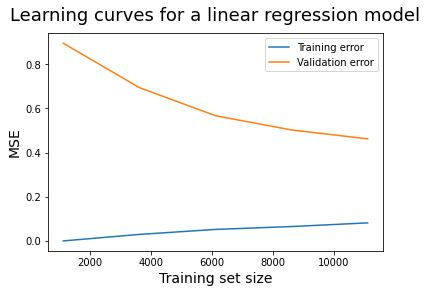

In [ ]:
# take means
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

# plot the results
plt.plot(train_size, train_scores_mean, label = 'Training error')
plt.plot(train_size, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()

# As the training set size increases, the two error lines start to converge which is a good sign and means the model is working properly (reference: https://www.dataquest.io/blog/learning-curves-machine-learning/)

# Part 3

Use scikit-learn’s Neural Network implementation to train and test the Neural Network

In [ ]:
# Hyperparameter tuning for hidden layer sizes and number of neurons
mlp = MLPClassifier(max_iter=1500)
hidden_layers = [(256,128), (150,100), (50,25), (24,12), (16,8), (5,2), (256,), (128,), (64,), (32,)]
param_grid = {'hidden_layer_sizes': hidden_layers}
mlp_cv = RandomizedSearchCV(mlp, param_grid, cv = 4)
mlp_cv.fit(x_tr,y_tr)

RandomizedSearchCV(cv=4, estimator=MLPClassifier(max_iter=1500),
                   param_distributions={'hidden_layer_sizes': [(256, 128),
                                                               (150, 100),
                                                               (50, 25),
                                                               (24, 12),
                                                               (16, 8), (5, 2),
                                                               (256,), (128,),
                                                               (64,), (32,)]})

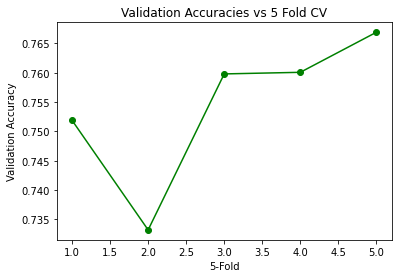

Mean Accuracy: 0.7543708722342514


In [ ]:
# cross validation on optimized number of layer and neurons
best_hidden_layer_size = mlp_cv.best_params_['hidden_layer_sizes']
mlp = MLPClassifier(hidden_layer_sizes=best_hidden_layer_size, max_iter=1500)
cv_results = cross_val_score(mlp, x_tr, y_tr, cv=5)
plt.plot([1,2,3,4,5], cv_results, marker='o', color='green')
plt.ylabel('Validation Accuracy')
plt.xlabel('5-Fold')
plt.title("Validation Accuracies vs 5 Fold CV")
plt.show()
print("Mean Accuracy:", cv_results.mean())


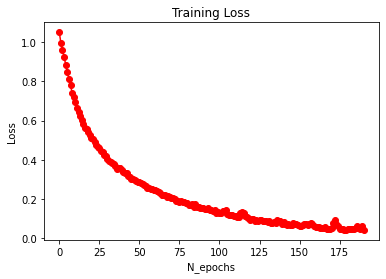

Accuracy:  77.38780207134639 %

Confusion Matrix:
[[ 773  142  134]
 [ 134 1120  131]
 [ 131  114  797]]

Classification Report: 
              precision    recall  f1-score   support

     English       0.74      0.74      0.74      1049
       Mixed       0.81      0.81      0.81      1385
        Urdu       0.75      0.76      0.76      1042

    accuracy                           0.77      3476
   macro avg       0.77      0.77      0.77      3476
weighted avg       0.77      0.77      0.77      3476



In [ ]:
# final training
nnhist = mlp.fit(x_tr,y_tr)
plt.plot(mlp.loss_curve_, marker='o', color='red')
plt.xlabel('N_epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# testing
y_pred = mlp.predict(x_te)

# evaluation
acc = accuracy_score(y_te, y_pred)
cm = confusion_matrix(y_te, y_pred)
print("Accuracy: ", acc*100, "%")
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report: ")
print(classification_report(y_te, y_pred))

# Ensemble Methods

In [ ]:
# improving accuracy of neural net using ensemble method of bagging classifier
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(base_estimator=mlp, n_estimators=10, random_state=0).fit(x_tr, y_tr)
y_pred = clf.predict(x_te)
acc = accuracy_score(y_te, y_pred)
cm = confusion_matrix(y_te, y_pred)
print("Accuracy: ", acc*100, "%")
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report: ")
print(classification_report(y_te, y_pred))

Accuracy:  80.17836593785961 %

Confusion Matrix:
[[ 809  139  101]
 [ 123 1172   90]
 [ 112  124  806]]

Classification Report: 
              precision    recall  f1-score   support

     English       0.77      0.77      0.77      1049
       Mixed       0.82      0.85      0.83      1385
        Urdu       0.81      0.77      0.79      1042

    accuracy                           0.80      3476
   macro avg       0.80      0.80      0.80      3476
weighted avg       0.80      0.80      0.80      3476



In [ ]:
# making a combined model from our 3 models using ensemble method of voting
from sklearn.ensemble import VotingClassifier
estimators=[('knn', knn), ('mlp', clf), ('svm', ksvm)]
ensemble = VotingClassifier(estimators, voting= 'hard')
ensemble.fit(x_tr, y_tr)
y_pred = ensemble.predict(x_te)

# evaluation of ensemble 
acc = accuracy_score(y_te, y_pred)
cm = confusion_matrix(y_te, y_pred)
print("Accuracy: ", acc*100, "%")
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report: ")
print(classification_report(y_te, y_pred))

Accuracy:  81.76064441887226 %

Confusion Matrix:
[[ 850  108   91]
 [ 139 1179   67]
 [ 133   96  813]]

Classification Report: 
              precision    recall  f1-score   support

     English       0.76      0.81      0.78      1049
       Mixed       0.85      0.85      0.85      1385
        Urdu       0.84      0.78      0.81      1042

    accuracy                           0.82      3476
   macro avg       0.82      0.81      0.81      3476
weighted avg       0.82      0.82      0.82      3476

